<h1>Battle of Neighborhoods </h1>


<h2>Location Analysis and Recommendation </h2>

<h4>Problem Statement:</h4> 
<P>A person wants to find a place for his stay in New York City. The person loves Asian food and hence wants to find a location where it is available. Using Foresquare API, the areas of the city are analyzed and explored to find an area with maximum number of Asian Restaurants. Furthermore, the avaibility of Market Places, Health Care Stores, Shopping Malls ,Salons etc are also to taken into consideration while finding the best location. Finally a list of all venues in the selected neighborhood is given and plotted on the map.  
    <P> A list of other requirements to be considered for the above problem are:
    
<h4>Essential Requirements:</h4>
<ol>
    <li>Bank</li>
    <li>Bakery</li>
    <li>Pharmacy</li>
    <li>Market/Store/Shop</li>
    <li>Salon</li>
    <li>Health and Beauty Service</li>
    <li>Gym</li>
     <li>Park</li>
    <li>Spa</li>
</ol>

<h4>Non-Essential Requirements:</h4>
<ol>
    <li>Tea Shop</li>
    <li>Tea Room</li>
</ol>
   

<h4>Objectives:</h4>
<ol>
    <li>To find out the Asian Restaurants in New York City </li>
    <li>To find the Borough with maximum Asian Restaurants</li>
    <li>To explore the neighborhoods for highest number of Asian Restaurants for the above result of the Borough </li>
    <li>To explore the above selected neighborhoods for the other requirements as per the list in the above problem statement.</li>
    <li>To find the neighborhood which fulfills most of the essential requirements</li>
    <li>To explore the neighborhood further and give a list of all venues in the area</li>
    <li>Cluster all the venues and the necessary venues on a map</li>
</ol>
<P>Based on the above findings,the most preferred area is suggested whose all venues are plotted as cluster on the map </P>
<P>Another neighborhood is suggested based on the next best suited area</P>
        
        

In [1]:
#importing libraries
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from pandas.io.json import json_normalize



from geopy.geocoders import Nominatim



import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans


import folium

import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


<h3> Loading and Cleaning Data</h3>

<h4>New York Data</h4>

The dataset is downloaded via the link: https://geo.nyu.edu/catalog/nyu_2451_34572 which is renamed as newyorkdata.csv for convenience.

In [2]:
df1=pd.read_csv("newyorkdata.csv")
df1.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


Finding the count of neighborhoods for each Borough of the given dataframe

In [3]:
 df1.groupby("Borough").count()

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


In [4]:
df1.shape

(306, 4)

<h4>Finding Latitudes and Longitudes of New York City</h4>

In [5]:
address = 'New York,NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


<h4>Visualizing the neighborhoods data for New York City as clusters</h4>

In [6]:
#creating map of New York using Latitude and Longitude values for Visualization
map_ny = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Borough'], df1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

<h4>Neighborhood count graph of each Borough</h4>

A graph is plotted with the Boroughs and the number of neighborhoods in each Borough to visualize the distribution of neighborhoods over each Brough.

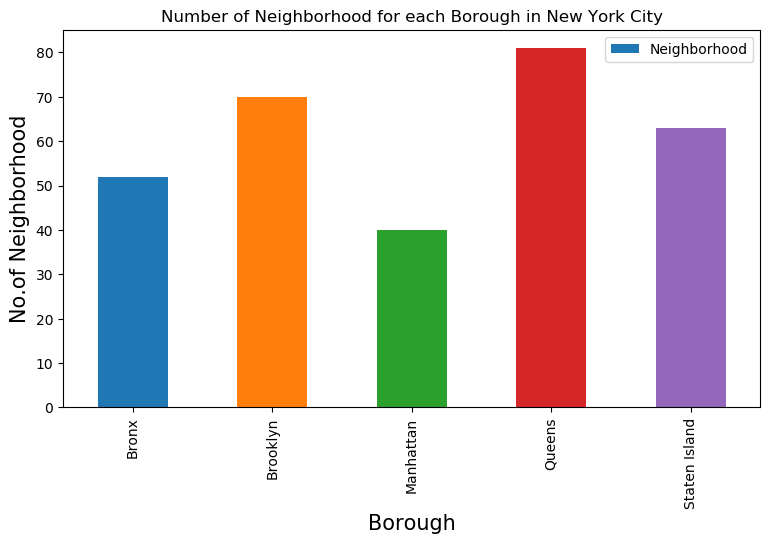

In [7]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df1.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<h3>Foresquare API</h3>

<h4>Getting the credentials</h4>

In [8]:
CLIENT_ID = '3G1FFILZXJ40SISIZQ32YIBEG5S0WTBLOFCOGKO3L2LFITXJ'
CLIENT_SECRET = 'EG1T4EMV1U3PNHEIGRPSBQZBSZPPTF2ETI45MX04O0FWU2MY' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3G1FFILZXJ40SISIZQ32YIBEG5S0WTBLOFCOGKO3L2LFITXJ
CLIENT_SECRET:EG1T4EMV1U3PNHEIGRPSBQZBSZPPTF2ETI45MX04O0FWU2MY


In [9]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
asian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in df1.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    asian_restaurants=venues[venues['Category']=='Asian Restaurant']   
    print('(',count,'/',len(df1),')','Asian Resturants in '+Neighborhood+', '+Borough+':'+str(len(asian_restaurants)))
    for restaurant_detail in asian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        asian_rest_ny = asian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Asian Resturants in Wakefield, Bronx:1
( 2 / 306 ) Asian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Asian Resturants in Eastchester, Bronx:2
( 4 / 306 ) Asian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Asian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Asian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Asian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Asian Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Asian Resturants in Norwood, Bronx:0
( 10 / 306 ) Asian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Asian Resturants in Baychester, Bronx:0
( 12 / 306 ) Asian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Asian Resturants in City Island, Bronx:0
( 14 / 306 ) Asian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Asian Resturants in University Heights, Bronx:0
( 16 / 306 ) Asian Resturants in Morris Heights, Bronx:1
( 17 / 306 ) Asian Resturants in Fordham, Bronx:0
( 18 / 306 ) Asian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Asian Resturants in W

( 146 / 306 ) Asian Resturants in Rego Park, Queens:2
( 147 / 306 ) Asian Resturants in Woodhaven, Queens:2
( 148 / 306 ) Asian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Asian Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Asian Resturants in College Point, Queens:2
( 151 / 306 ) Asian Resturants in Whitestone, Queens:1
( 152 / 306 ) Asian Resturants in Bayside, Queens:3
( 153 / 306 ) Asian Resturants in Auburndale, Queens:0
( 154 / 306 ) Asian Resturants in Little Neck, Queens:1
( 155 / 306 ) Asian Resturants in Douglaston, Queens:0
( 156 / 306 ) Asian Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Asian Resturants in Bellerose, Queens:0
( 158 / 306 ) Asian Resturants in Kew Gardens Hills, Queens:2
( 159 / 306 ) Asian Resturants in Fresh Meadows, Queens:2
( 160 / 306 ) Asian Resturants in Briarwood, Queens:1
( 161 / 306 ) Asian Resturants in Jamaica Center, Queens:0
( 162 / 306 ) Asian Resturants in Oakland Gardens, Queens:1
( 163 / 306 ) Asian Resturants in Queens Vil

( 285 / 306 ) Asian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Asian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Asian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Asian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Asian Resturants in Roxbury, Queens:0
( 290 / 306 ) Asian Resturants in Homecrest, Brooklyn:1
( 291 / 306 ) Asian Resturants in Middle Village, Queens:0
( 292 / 306 ) Asian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Asian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Asian Resturants in Richmond Valley, Staten Island:1
( 295 / 306 ) Asian Resturants in Malba, Queens:0
( 296 / 306 ) Asian Resturants in Highland Park, Brooklyn:0
( 297 / 306 ) Asian Resturants in Madison, Brooklyn:0
( 298 / 306 ) Asian Resturants in Bronxdale, Bronx:0
( 299 / 306 ) Asian Resturants in Allerton, Bronx:0
( 300 / 306 ) Asian Resturants in Kingsbridge Heights, Bronx:0
( 301 / 306 ) Asian Resturants in Erasmus, Brook

In [11]:
asian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4dbf038d432d1849fa379c49,excellent taste restaurant
1,Bronx,Eastchester,50f9fef3e4b0c2329117b8a8,Yumi Asian Bistro & Hibachi Steak House
2,Bronx,Eastchester,4c0dac537189c928c871d7b6,Jimmy's Best Chinese Restaurant
3,Bronx,Morris Heights,4babfacaf964a5203bdb3ae3,Chop Chop
4,Bronx,Mott Haven,4f9de99ae4b08ea03a934ce3,Ceetay


<h4>Bar Graph for number of Asian Resturants in each Borough</h4>

A graph is plotted between the bOroughs and count of Asian Restaurants in each Borough to find where maximum of it is available

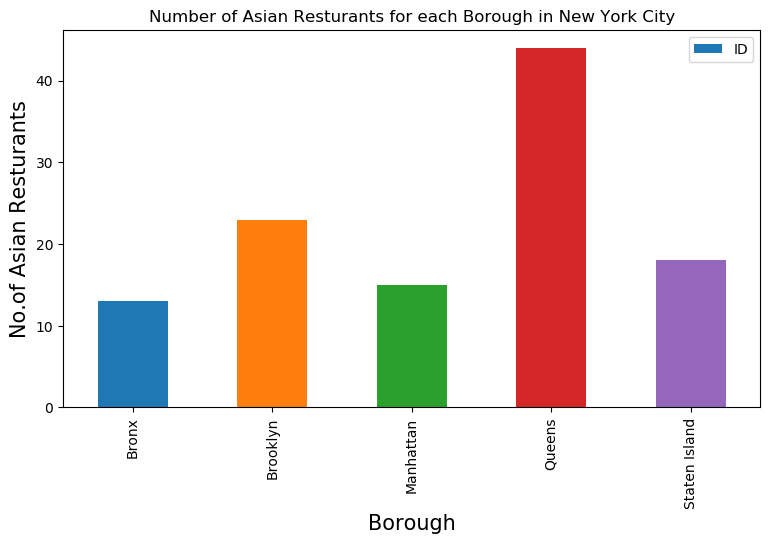

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Asian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Asian Resturants', fontsize=15)
#giving a bar plot
asian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<h4>Graph Analysis</h4>

<h5>From the above graph,it is clear that Queens has a maximum number of Asian Restaurants.<h5>

<h4>Exploring Queens</h4>

1) From the obtained dataframe of Asian Restaurants using Foresquare API,we slice the dataframe to find the data for Queens.

In [13]:
queens_data = asian_rest_ny[asian_rest_ny['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,ID,Name
0,Queens,Astoria,5834f3a437da1d46fb028a5e,Rice K
1,Queens,Jackson Heights,4d6d7ebcfbf0a0934fc7008d,Lali Guras Restaurant
2,Queens,Elmhurst,4d6d7ebcfbf0a0934fc7008d,Lali Guras Restaurant
3,Queens,Elmhurst,56b25deb498ebc3a62af6179,Little House Cafe 聚香园茶餐厅
4,Queens,Forest Hills,4eb6fa550aaf1abedff6cba5,MoCA Asian Bistro


2) From the dataset newyork.csv stored in the dataframe,all Queens data is seperated into a new dataframe

In [14]:
queen = df1[df1['Borough'] == 'Queens'].reset_index(drop=True)
queen.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


<h3>Plotting a graph to find out the neighborhoods of Queens and their count of Asian Restaurants</h3>

A graph is plotted between the neighborhoods of Queens and their count of Asian Restaurants to find the neighborhoods with maximum of it.

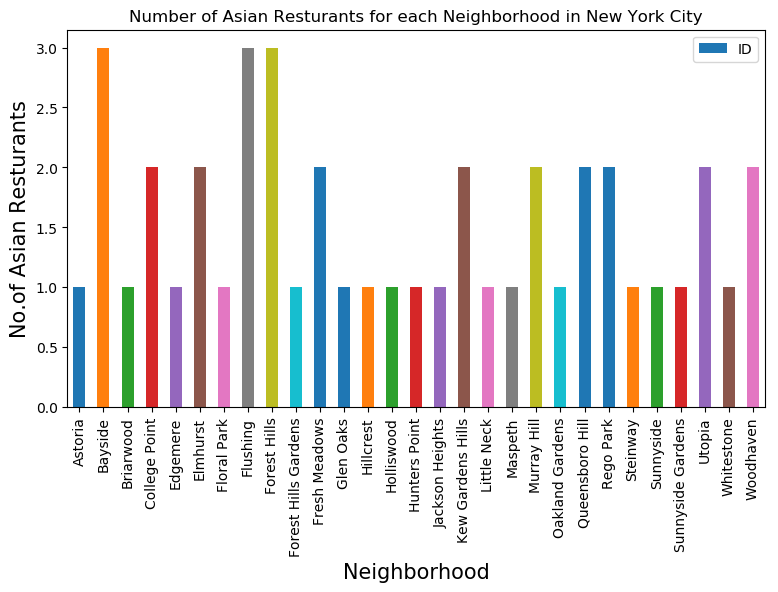

In [15]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Asian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Asian Resturants', fontsize=15)
#giving a bar plot
queens_data .groupby('Neighborhood')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<h4>Graph Analysis:</h4>

<h5>From the above graph,it is found that the neighborhoods-Bayside,Flushing and Forest Hills have equal number of Asian Restaurants which is highest among the other neighborhoods</h5>

<h4>Exploring Neighborhoods</h4>

In [16]:
#function generating the url for each neighborhood
def urlfunc(neighborhood_latitude,neighborhood_longitude):
    LIMIT = 100 
    radius = 1000


    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    return url

In [17]:
#getting request and examining the results
def urlreq(url):
    results = requests.get(url).json()
    return results

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<h4>Exploring Bayside</h4>

In [19]:
queen.loc[22, 'Neighborhood']

'Bayside'

In [20]:
#finding neighbourhood's latitudal and longitudnal values
neighborhood_latitude = queen.loc[22, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = queen.loc[22, 'Longitude'] # neighborhood longitude value

neighborhood_name = queen.loc[22, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
a=urlfunc(neighborhood_latitude,neighborhood_longitude)#calling function to generate the url
print(a)
b=urlreq(a)



Latitude and longitude values of Bayside are 40.76604063281064, -73.77427363068671.
https://api.foursquare.com/v2/venues/explore?&client_id=3G1FFILZXJ40SISIZQ32YIBEG5S0WTBLOFCOGKO3L2LFITXJ&client_secret=EG1T4EMV1U3PNHEIGRPSBQZBSZPPTF2ETI45MX04O0FWU2MY&v=20180605&ll=40.76604063281064,-73.77427363068671&radius=1000&limit=100


In [21]:
#cleaning the json structure into pandas dataframe
results=urlreq(a)
venues = results['response']['groups'][0]['items']
    
nearby_venues1 = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues1 =nearby_venues1.loc[:, filtered_columns]

# filter the category for each row
nearby_venues1['venue.categories'] = nearby_venues1.apply(get_category_type, axis=1)

# clean columns
nearby_venues1.columns = [col.split(".")[-1] for col in nearby_venues1.columns]

nearby_venues1.head()

,name,categories,lat,lng
0,The French Workshop,Bakery,40.765404,-73.771861
1,Avli Little Greek Tavern,Greek Restaurant,40.765729,-73.771972
2,Nippon Cha,Noodle House,40.764408,-73.771461
3,Ayna Agra Indian Restaurant,Indian Restaurant,40.765478,-73.771737
4,Fino Wine & Tapas,Wine Bar,40.764952,-73.771557


<h4>Slicing the dataframe for required categories</h4>

The venue dataframe for the neighborhood "Bayside" is sliced into a new dataframe containing only the desired categories for the analysis as below

In [22]:
new =nearby_venues1[(nearby_venues1['categories'].isin(['Bank','Gym','Bubble Tea Shop','Bakery','Salon / Barbershop','Pharmacy','Park','Health & Beauty Service','Gym / Fitness Center','Supermarket','Supplement Shop','Grocery Store','Department Store','Tea Room','Spa']))]
new.head()

,name,categories,lat,lng
0,The French Workshop,Bakery,40.765404,-73.771861
7,Martha's Country Bakery,Bakery,40.763422,-73.770971
11,Massage Envy,Spa,40.766402,-73.772202
26,Crocheron Park,Park,40.772293,-73.769168
28,Better Body Bootcamp,Gym,40.769062,-73.773797


<h4>Visualization of the avaibility counts</h4>

A graph is plotted between the selected categories and their counts for the neighborhood for further comparison with the avaibility of the desired in other neighborhoods

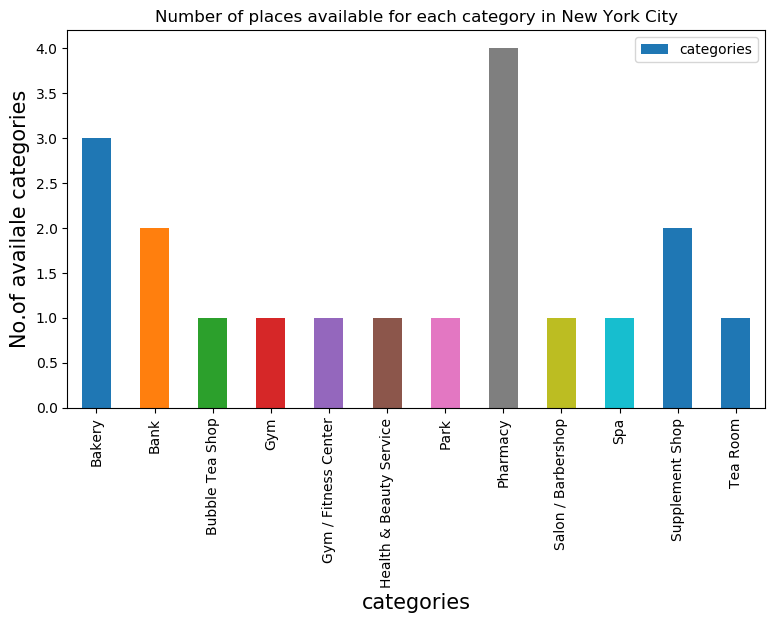

In [23]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of places available for each category in New York City')
#On x-axis
plt.xlabel('Categories', fontsize = 15)
#On y-axis
plt.ylabel('No.of availale categories', fontsize=15)
#giving a bar plot
new.groupby('categories')['categories'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [24]:
print(new['categories'].value_counts())

Pharmacy                   4
Bakery                     3
Supplement Shop            2
Bank                       2
Gym / Fitness Center       1
Spa                        1
Salon / Barbershop         1
Tea Room                   1
Health & Beauty Service    1
Bubble Tea Shop            1
Park                       1
Gym                        1
Name: categories, dtype: int64


<h5>Note:
<P>For the requirement of Market/Store/Shop,Bayside has a Supplement Store. 
<P>For the requirement of Tea Shop,Bayside has Bubble Tea Shop.</h5>

<h4>Exploring Flushing</h4>

In [25]:
queen.loc[9, 'Neighborhood']

'Flushing'

In [26]:
#finding neighbourhood's latitudal and longitudnal values
neighborhood_latitude = queen.loc[9, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = queen.loc[9, 'Longitude'] # neighborhood longitude value

neighborhood_name = queen.loc[9, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
a=urlfunc(neighborhood_latitude,neighborhood_longitude)#calling function to generate the url
print(a)
b=urlreq(a)#calling function to get the results for examining them


Latitude and longitude values of Flushing are 40.76445419697846, -73.83177300329581.
https://api.foursquare.com/v2/venues/explore?&client_id=3G1FFILZXJ40SISIZQ32YIBEG5S0WTBLOFCOGKO3L2LFITXJ&client_secret=EG1T4EMV1U3PNHEIGRPSBQZBSZPPTF2ETI45MX04O0FWU2MY&v=20180605&ll=40.76445419697846,-73.83177300329581&radius=1000&limit=100


In [27]:
#cleaning the json structure into pandas dataframe
results=urlreq(a)
venues = results['response']['groups'][0]['items']
    
nearby_venues2 = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues2 =nearby_venues2.loc[:, filtered_columns]

# filter the category for each row
nearby_venues2['venue.categories'] = nearby_venues2.apply(get_category_type, axis=1)

# clean columns
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]

nearby_venues2.head()

,name,categories,lat,lng
0,Debasaki,Korean Restaurant,40.764852,-73.831767
1,Little Sheep Mongolian Hot Pot 小肥羊,Hotpot Restaurant,40.762083,-73.828963
2,New York Badminton Center,Gym / Fitness Center,40.765300,-73.834438
3,Flushing Town Hall,Performing Arts Venue,40.763623,-73.830139
4,Joo Mak Gol Korean Restaurant,Food,40.763658,-73.831737


<h4>Slicing the dataframe for required categories</h4>

The venue dataframe for the neighborhood "Flushing" is sliced into a new dataframe containing only the desired categories for the analysis as below

In [28]:
new1 =nearby_venues2[(nearby_venues2['categories'].isin(['Bank','Gym','Bubble Tea Shop','Bakery','Salon / Barbershop','Pharmacy','Park','Health & Beauty Service','Gym / Fitness Center','Supermarket','Grocery Store','Department Store','Tea Room','Spa']))]
new1.head()

,name,categories,lat,lng
2,New York Badminton Center,Gym / Fitness Center,40.765300,-73.834438
6,Bodhi Fitness Center,Gym,40.763666,-73.833211
8,Fang Gourmet Tea,Tea Room,40.759342,-73.830955
14,Möge Tee,Bubble Tea Shop,40.760781,-73.830610
15,Prince Tea House,Tea Room,40.761275,-73.832847


<h4>Visualization of the avaibility counts</h4>

A graph is plotted between the selected categories and their counts for the neighborhood for further comparison with the avaibility of the desired in other neighborhoods

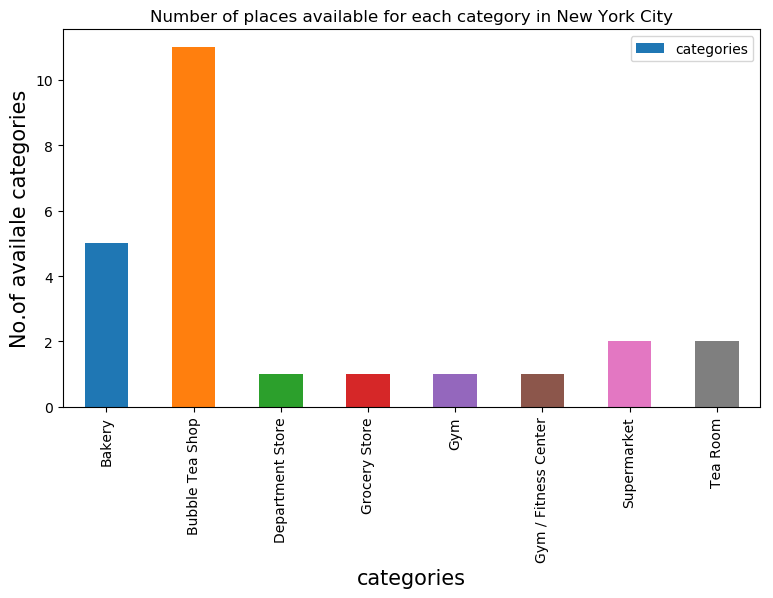

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of places available for each category in New York City')
#On x-axis
plt.xlabel('Categories', fontsize = 15)
#On y-axis
plt.ylabel('No.of availale categories', fontsize=15)
#giving a bar plot
new1.groupby('categories')['categories'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<h4>Graph Analysis:</h4>

From the graph,the number of desired categories available is seen whose summary is printed below

In [30]:
print(new1['categories'].value_counts())

Bubble Tea Shop         11
Bakery                   5
Supermarket              2
Tea Room                 2
Grocery Store            1
Gym / Fitness Center     1
Department Store         1
Gym                      1
Name: categories, dtype: int64


<h5>Note:
<P>For the requirement of Market/Store/Shop, Flushing has a Grocery Store,a Department Store and a Supermarket. 
<P>For the requirement of Tea Shop,Flushing has Bubble Tea Shop.</h5>

<h4>Exploring Forest Hills</h4>

In [31]:
queen.loc[6, 'Neighborhood']

'Forest Hills'

In [32]:
#finding neighbourhood's latitudal and longitudnal values
neighborhood_latitude = queen.loc[6, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = queen.loc[6, 'Longitude'] # neighborhood longitude value

neighborhood_name = queen.loc[6, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
a=urlfunc(neighborhood_latitude,neighborhood_longitude)#calling function to generate the url
print(a)
b=urlreq(a)#calling function to get the results for examining them


Latitude and longitude values of Forest Hills are 40.72526378216503, -73.84447500788983.
https://api.foursquare.com/v2/venues/explore?&client_id=3G1FFILZXJ40SISIZQ32YIBEG5S0WTBLOFCOGKO3L2LFITXJ&client_secret=EG1T4EMV1U3PNHEIGRPSBQZBSZPPTF2ETI45MX04O0FWU2MY&v=20180605&ll=40.72526378216503,-73.84447500788983&radius=1000&limit=100


In [33]:
#cleaning the json structure into pandas dataframe
results=urlreq(a)
venues = results['response']['groups'][0]['items']
    
nearby_venues3 = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues3 =nearby_venues3.loc[:, filtered_columns]

# filter the category for each row
nearby_venues3['venue.categories'] = nearby_venues3.apply(get_category_type, axis=1)

# clean columns
nearby_venues3.columns = [col.split(".")[-1] for col in nearby_venues3.columns]

nearby_venues3.head()

,name,categories,lat,lng
0,Forest Hills Bagels,Bagel Shop,40.723600,-73.847820
1,Yellowstone Park,Park,40.726251,-73.847759
2,iLoveKickboxing,Boxing Gym,40.721522,-73.847939
3,Banter,Bar,40.720820,-73.843169
4,Martha's Country Bakery,Bakery,40.720558,-73.845883


<h4>Slicing the dataframe for required categories</h4>

The venue dataframe for the neighborhood "Forest Hils" is sliced into a new dataframe containing only the desired categories for the analysis as below

In [34]:
new2 =nearby_venues3[(nearby_venues3['categories'].isin(['Bank','Gym','Bubble Tea Shop','Bakery','Salon / Barbershop','Pharmacy','Park','Health & Beauty Service','Gym / Fitness Center','Supermarket','Department Store','Grocery Store','Tea Room','Spa']))]
new2.head()

,name,categories,lat,lng
1,Yellowstone Park,Park,40.726251,-73.847759
4,Martha's Country Bakery,Bakery,40.720558,-73.845883
9,European Wax Center,Health & Beauty Service,40.720939,-73.846729
18,MacDonald Park,Park,40.722239,-73.847141
23,La Boulangerie,Bakery,40.719112,-73.841493


<h4>Visualization of the avaibility counts</h4>

A graph is plotted between the selected categories and their counts for the neighborhood for further comparison with the avaibility of the desired in other neighborhoods

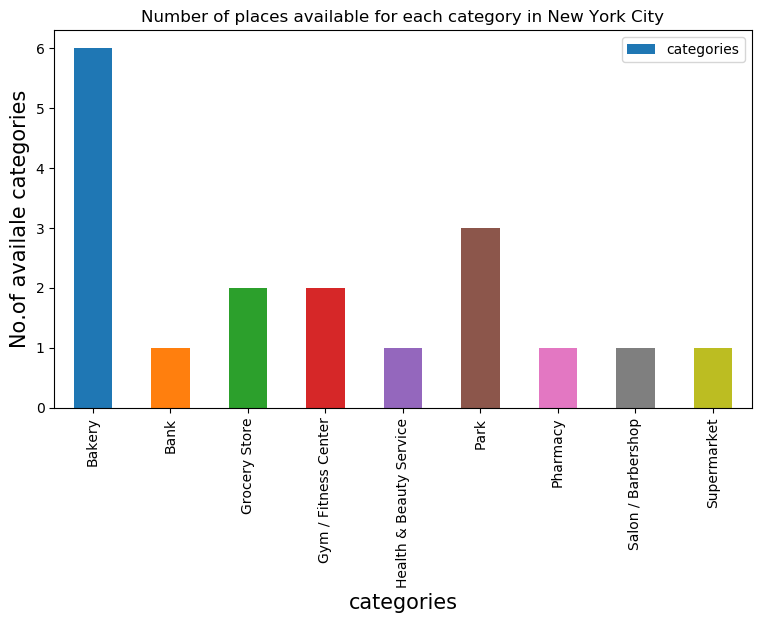

In [35]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of places available for each category in New York City')
#On x-axis
plt.xlabel('Categories', fontsize = 15)
#On y-axis
plt.ylabel('No.of availale categories', fontsize=15)
#giving a bar plot
new2.groupby('categories')['categories'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<h4>Graph Analysis:</h4>

From the graph,the number of desired categories available is seen whose summary is printed below

In [36]:
print(new2['categories'].value_counts())

Bakery                     6
Park                       3
Grocery Store              2
Gym / Fitness Center       2
Supermarket                1
Health & Beauty Service    1
Salon / Barbershop         1
Pharmacy                   1
Bank                       1
Name: categories, dtype: int64


<h5>Note:
For the requirement of Market/Store/Shop, Forest Hills has a Grocery Store and a Supermarket</h5>

<h3>Best Suited Neighborhood Recommendation</h3>

Comparing the avaibility of the requirements in the three neighborhoods,the best suited neighborhood is Forest Hills.It is chosen because despite the less count of a few categories available,it fulfills almost all the requirement list as per the problem for a radius of 1000 meters.
        The second recommendation is Bayside.
        
<h5><ol>
    <li>Forest Hills</li>
    <li>Bayside</li>
    </ol></h5>

<h3>Analysis of Forest Hills</h3>

In [37]:
print("List of all venues in Forest Hills:")

print(nearby_venues3[['name','categories']])

List of all venues in Forest Hills:
                                       name                 categories
0                       Forest Hills Bagels                 Bagel Shop
1                          Yellowstone Park                       Park
2                           iLoveKickboxing                 Boxing Gym
3                                    Banter                        Bar
4                   Martha's Country Bakery                     Bakery
5                           Bangkok Cuisine            Thai Restaurant
6                Forest Hills Station House               Cocktail Bar
7                              Zen and Yoga                Yoga Studio
8                        Tu Casa Restaurant        Peruvian Restaurant
9                       European Wax Center    Health & Beauty Service
10                                 Kissfish         Seafood Restaurant
11                   Ripe Juice Bar & Grill                  Juice Bar
12                               Bareburg

<h4>Getting the coordinates of Forest Hills</h4>

In [38]:
latitude = queen.loc[6, 'Latitude'] # neighborhood latitude value
longitude = queen.loc[6, 'Longitude'] # neighborhood longitude value

neighborhood_name = queen.loc[6, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               latitude, 
                                                               longitude))

Latitude and longitude values of Forest Hills are 40.72526378216503, -73.84447500788983.


<h4>Clustering All the venues of Forest Hills</h4>

In [39]:
map_ny1 = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, cat, name in zip(nearby_venues3['lat'], nearby_venues3['lng'], nearby_venues3['categories'], nearby_venues3['name']):
    label = '{}, {}'.format(cat, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny1)  
    
map_ny1

<h4>Clustering only the desired requirements of Forest Hills</h4>

In [40]:
map_ny2 = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, cat, name in zip(new2['lat'], new2['lng'], new2['categories'],new2['name']):
    label = '{}, {}'.format(cat, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny2)  
    
map_ny2